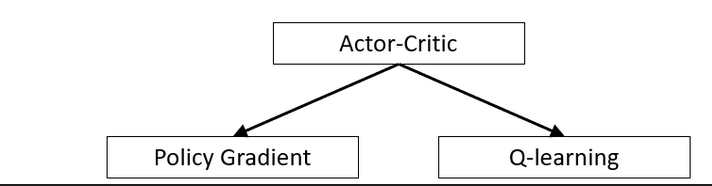

In [9]:
from IPython.display import Image
Image("image_1.png")


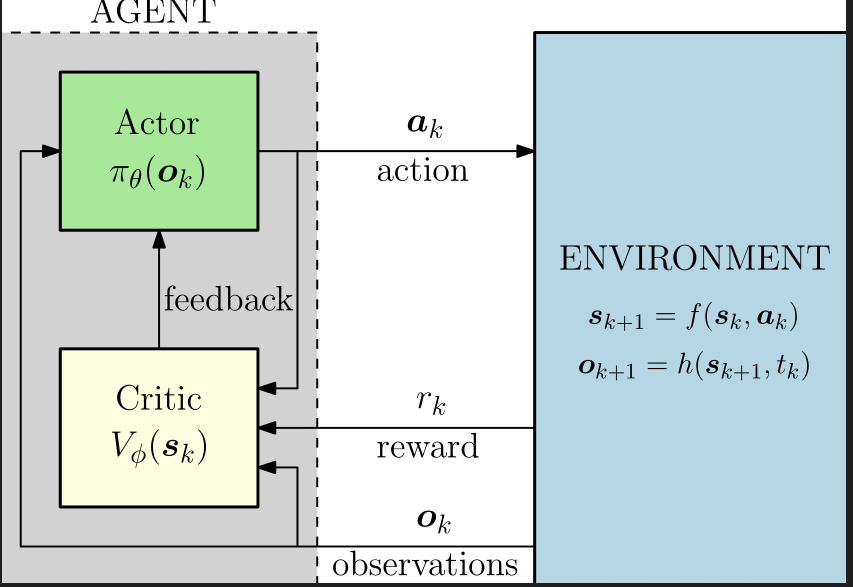

In [10]:
from IPython.display import Image
Image("image_2.png")


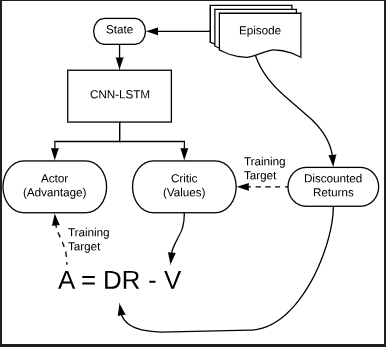

In [11]:
from IPython.display import Image
Image("image_3.png")

In [1]:


import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import random
import pylab
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Lambda, Add, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import cv2
from gym.envs.registration import register

Defining The Model 

In [2]:
def OurModel(input_shape, action_space, lr):
    X_input = Input(input_shape)

    
    X = Flatten(input_shape=input_shape)(X_input)

    X = Dense(512, activation="elu", kernel_initializer='he_uniform')(X)
    

    direction_output = Dense(action_space[0], activation="softmax", kernel_initializer='he_uniform', name='direction')(X)
    selection_node_output = Dense(action_space[1], activation="softmax", kernel_initializer='he_uniform', name='selection_node')(X)
    value_output = Dense(1, kernel_initializer='he_uniform')(X)

    Actor = Model(inputs=X_input, outputs=[direction_output, selection_node_output])
    Actor.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=lr))

    Critic = Model(inputs = X_input, outputs = value_output)
    Critic.compile(loss='mse', optimizer=RMSprop(lr=lr))

    return Actor, Critic

In [4]:
class A2CAgent:
    def __init__(self,environment):
        self.env=environment
        self.action_size=(6,5) #we have six diirections and 5 nodes for the auv to select from
        self.EPISODES=10
        self.state_size = (3,1)  # for now I'll take the state as only the auv current position (x,y,z)

        self.lr = 0.000025
        self.states, self.actions, self.rewards = [], [], []

        self.Save_Path = 'training\saved_models'
        if not os.path.exists(self.Save_Path): os.makedirs(self.Save_Path)
        self.path = '{}_A2C_{}'.format(self.env, self.lr)
        self.Model_name = os.path.join(self.Save_Path, self.path)

        self.Actor, self.Critic = OurModel(input_shape=self.state_size, action_space = self.action_size,lr=self.lr)

    

    def remember(self, state, action, reward):

        self.states.append(state)
        self.actions.append(action)  
        self.rewards.append(reward)

    
    def act(self,state):
        state = state.reshape((1,3))
        direction_probs,selection_node_probs=self.Actor.predict(state)
        direction = np.random.choice(6, p=direction_probs[0])
        selection_node = np.random.choice(5, p=selection_node_probs[0])
        
        return direction,selection_node
    
    def discount_rewards(self, reward):
        gamma = 0.99  # The discount rate will be set to this value
        discounted_r = np.zeros_like(reward)
        running_add = 0

    # we Compute discounted rewards for each time step
        for t in reversed(range(len(reward))):
            running_add = running_add * gamma + reward[t]
            discounted_r[t] = running_add

        return discounted_r
    
    def replay(self):
        states=np.vstack(self.states)
        actions_dir,actions_selection_node=np.vstack([ act[0] for act in self.actions]), np.vstack([act[1] for act in self.actions])
        discounted_r=self.discount_rewards(self.rewards)
        values=self.Critic.predict(states)[:,0]
        advantages=discounted_r - values
        self.Actor.fit(states, [actions_dir, actions_selection_node], sample_weight=[advantages,advantages], epochs=1, verbose=0)
        self.Critic.fit(states, discounted_r, epochs=1, verbose=0)

        self.states, self.actions, self.rewards = [], [], []     #  For Reseting the  training memory

    def load(self, Actor_name, Critic_name):
        self.Actor = load_model(Actor_name, compile=False)
        #self.Critic = load_model(Critic_name, compile=False)

    def save(self):
        self.Actor.save(self.Model_name + '_Actor.h5')
        #self.Critic.save(self.Model_name + '_Critic.h5')

    def step(self, action):
        next_state, reward, done, info = self.env.step(action)
        
        return next_state, reward, done, info
    def run(self):
        for e in range(self.EPISODES):
            state = self.env.reset()
            done, score, SAVING = False, 0, ''
            while not done:
                #self.env.render()
                # Actor picks an action
                action = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.step(action)
                # Memorize (state, action, reward) for training
                self.remember(state, action, reward)
                # Update current state
                state = next_state
                score += reward
                if done:
                    
                    print("episode: {}/{}, score: {}, {}".format(e, self.EPISODES, score, SAVING))

                    #self.replay()
                    self.states, self.actions, self.rewards = [], [], []
        # close environemnt when finish training
            self.env.close()
         
    



    


    






In [5]:
from setting_the_environment import AUVEnvironment  

   
env = AUVEnvironment()

agent = A2CAgent(env)
agent.run()

1/1 [==============================] - 0s 24ms/step
episode: 0/10, score: 93.2770605330317, 
1/1 [==============================] - 0s 24ms/step
episode: 1/10, score: 86.23438305525198, 
1/1 [==============================] - 0s 24ms/step
episode: 2/10, score: 88.19897655063454, 
1/1 [==============================] - 0s 27ms/step
episode: 3/10, score: 90.22848197267905, 
1/1 [==============================] - 0s 24ms/step
episode: 4/10, score: 89.72076613403105, 
1/1 [==============================] - 0s 24ms/step
episode: 5/10, score: 84.98272258219674, 
1/1 [==============================] - 0s 16ms/step
episode: 6/10, score: 87.48397721194969, 
1/1 [==============================] - 0s 24ms/step
episode: 7/10, score: 88.20841100088197, 
1/1 [==============================] - 0s 24ms/step
episode: 8/10, score: 87.32191565220069, 
1/1 [==============================] - 0s 16ms/step
episode: 9/10, score: 87.96632447554052, 
